In [53]:
import geopandas as gpd
from matplotlib import pyplot
import pandas as pd
import pycrs
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

In [20]:
land_cover = rasterio.open('data/LC1162809098/LC1162809098\LC1162809098.tif')
smith_county = gpd.read_file('data/county outline/county outline.shp')

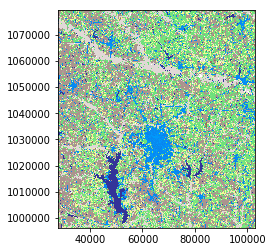

In [21]:
show((land_cover, 1), cmap='terrain')

In [44]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

geo = smith_county.to_crs(crs=land_cover.crs.data)
coords = getFeatures(geo)

clipped_img, clipped_transform = mask(land_cover, shapes=coords, crop=True)
clipped_meta = land_cover.meta.copy()

clipped_meta.update({
    "driver": "GTiff",
    "height": clipped_img.shape[1],
    "width": clipped_img.shape[2],
    "transform": clipped_transform
})

with rasterio.open('data/clipped.tif', "w", **clipped_meta) as dest:
    dest.write(clipped_img)

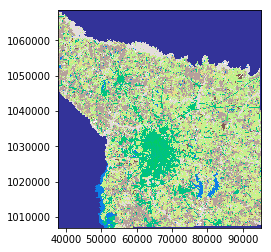

In [45]:
clipped = rasterio.open('data/clipped.tif')

show((clipped, 1), cmap='terrain')

In [70]:
data = clipped.read(1)

In [71]:
unique, counts = np.unique(data, return_counts=True)

In [75]:
df = pd.DataFrame({
    'value': unique,
    'count': counts
})

In [77]:
df['class'] = df['value'].map({
    11: 'Water',
    21: 'Developed',
    22: 'Developed',
    23: 'Developed',
    24: 'Developed',
    31: 'Barren',
    41: 'Forest',
    42: 'Forest',
    43: 'Forest',
    52: 'Shrubland',
    71: 'Herbaceous',
    81: 'Planted/Cultivated',
    82: 'Planted/Cultivated',
    90: 'Wetlands',
    95: 'Wetlands'    
})

In [84]:
df = df.groupby('class').agg({'count': 'sum'})

In [85]:
df['share'] = df['count'] / sum(df['count']) * 100

In [86]:
df

,count,share
class,,
Barren,9771,0.357428
Developed,400644,14.655741
Forest,870876,31.857044
Herbaceous,27390,1.001939
Planted/Cultivated,729277,26.677287
Shrubland,269074,9.842850
Water,69015,2.524600
Wetlands,357653,13.083111
